# Initiate

In [ ]:
import time
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine, euclidean

openai.api_key = os.environ['OPENAI_API_KEY']
np.set_printoptions(precision=3, suppress=True)

REFRESH = False

def get_embedding(text, sleep=0):
    '''Compute GPT3-embedding for a given text string'''
    time.sleep(sleep)
    result = openai.Embedding.create(input=text, model='text-embedding-ada-002')
    return np.array(result.data[0].embedding)

messages = pd.read_csv('data/messages.csv').drop(columns='Unnamed: 0')
messages.index = [f'Message_{i}' for i in messages.index]
images = pd.read_csv('data/images.csv').drop(columns='Unnamed: 0')
images.index = [f'Image_{i}' for i in images.index]

# Get Embedding Dataframes

In [47]:
def glue(row):
    return ' '.join(row[['age', 'race', 'gender']].values).lower()

In [54]:
def define_age(age: int):
    age = int(age)
    ages = {
        'baby': range(4),
        'child': range(4, 12),
        'teenager': range(12, 18),
        'young': range(18, 24),
        'young adult': range(24, 35),
        'adult': range(35, 60),
        'senior-aged': range(60, 2000)
    }
    for category, range_ in ages.items():
        if age in range_:
            return category
    return Exception('Do you know how ages are measured?')

In [ ]:
path_test_vector = 'data/embeddings/test_vector'
if REFRESH:
    test_vector = get_embedding('test')
    np.save(path_test_vector, test_vector)
else:
    test_vector = np.load(
        f'{path_test_vector}.npy',
        allow_pickle=True
    )

In [62]:
df_people = pd.read_csv('./data/users.csv')
gender = df_people.gender.apply(lambda x: 'man' if x == 'Male' else 'woman')
age = df_people.age.apply(lambda x: define_age(x))
race = df_people.race.str.lower()
description = age + ' ' + race + ' ' + gender
df_people['description'] = description
likes_sep = ';'
df_people['likes'] = df_people['likes'].str.split(likes_sep)
df_people['dislikes'] = df_people['dislikes'].str.split(likes_sep)
df_people.index = [f'Person_{i}' for i in df_people.index]
df_people.head(1)

,gender,age,race,likes,dislikes,description
Person_0,Male,45,White,"[physical, creative, music, active]","[sports, games, cerebral, domestic]",adult white man


In [69]:
path_activities = 'data/embeddings/activities_embeddings.csv'
if REFRESH:
    activities = []
    for person in df_people.iterrows():
        person = person[1]
        for attitude in ['likes', 'dislikes']:
            for activity in person[attitude]:
                if activity not in activities:
                    activities.append(activity)
    activities.sort()
    activities = {activity: get_embedding(activity) for activity in activities}
    df_activities = pd.DataFrame(activities)
    df_activities.to_csv(path_activities, index=False)
else:
    df_activities = pd.read_csv(path_activities)


In [72]:
def prepare(df):
    """
    center and normalize each point of the vector from -1 to 1
    compared to the neighbouring entities.
    Each feature inside of 1536 long-vector is normalized separately
    according to the observations of the same feature in other entities.
    """
    df_ = df.copy()
    mean = df_.mean(axis='columns')
    df_ = df_.apply(lambda column: column - mean, axis='rows')
    min_ = df_.apply(lambda row: row.min(), axis='columns')
    max_ = df_.apply(lambda row: row.max(), axis='columns')
    df_ = df_.apply(
        lambda column: 2 * (column - min_) / (max_ - min_) - 1,
        axis='rows'
    )
    return df_

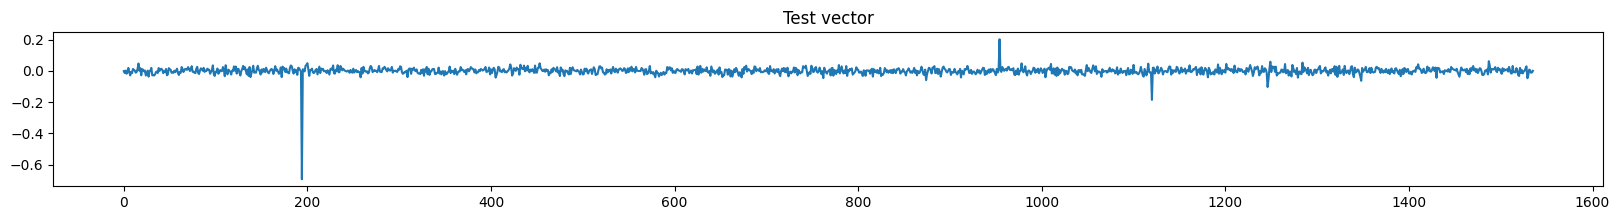

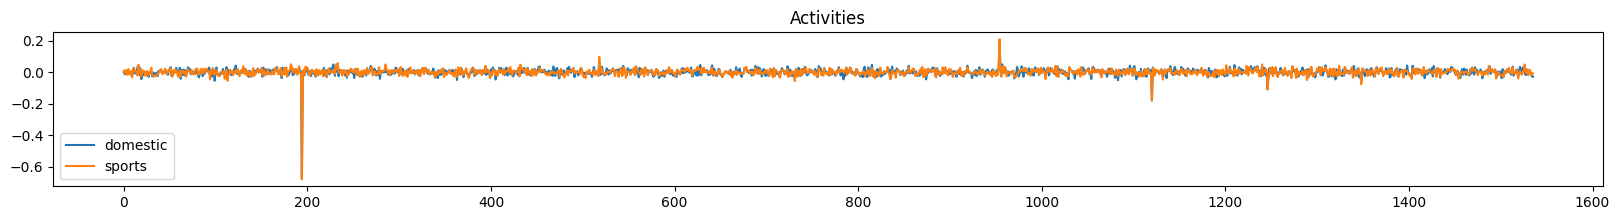

In [75]:
plt.figure(figsize=(20,2))
plt.plot(test_vector)
plt.title('Test vector')
plt.show()
plt.figure(figsize=(20,2))
plt.title('Activities')
# for activity in activities:
#     plt.plot(df_activities[activity], label=activity)
plt.plot(df_activities['domestic'], label='domestic')
plt.plot(df_activities['sports'], label='sports')
plt.legend()
plt.show()

In [76]:
df_activities = prepare(df_activities)

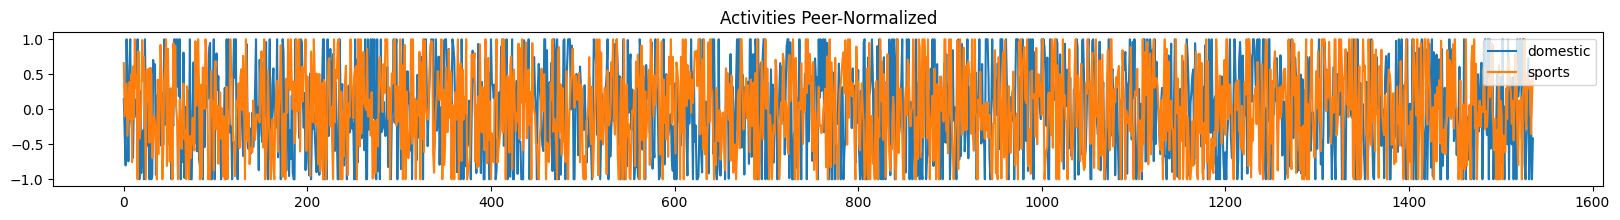

In [81]:
plt.figure(figsize=(20,2))
# for activity in activities:
#     plt.plot(df_activities[activity])
plt.plot(df_activities['domestic'], label='domestic')
plt.plot(df_activities['sports'], label='sports')
plt.legend()
plt.title('Activities Peer-Normalized')
plt.show()

In [98]:
path_people_descriptions = 'data/embeddings/people_descriptions_embeddings.csv'
if REFRESH:
    people_descriptions = {id: get_embedding(description) for id, description in zip(df_people.index, df_people.description)}
    df_people_descriptions = pd.DataFrame(people_descriptions)
    df_people_descriptions.to_csv(path_people_descriptions, index=False)
else:
    df_people_descriptions = pd.read_csv(path_people_descriptions)


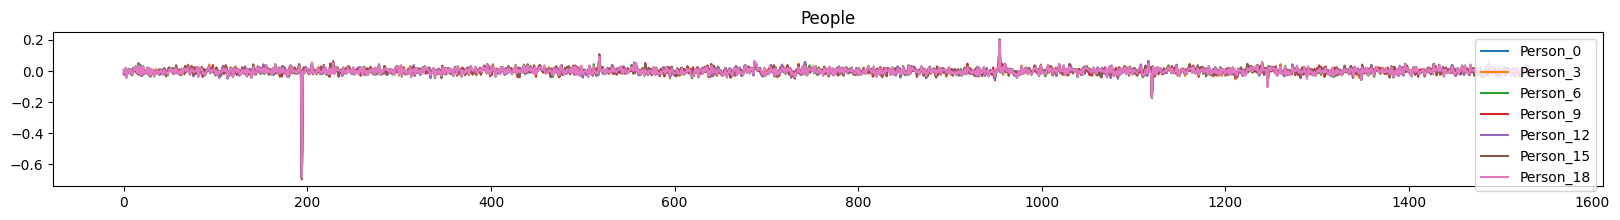

In [101]:
plt.figure(figsize=(20,2))
plt.title('People')
for person in df_people.index[::3]:
    plt.plot(df_people_descriptions[person], label=person)
plt.legend()
plt.show()

In [102]:
df_people_descriptions = prepare(df_people_descriptions)

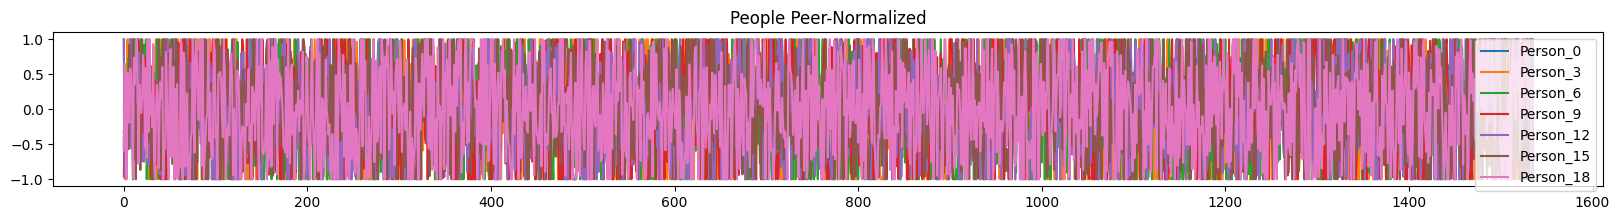

In [104]:
plt.figure(figsize=(20,2))
plt.title('People Peer-Normalized')
for person in df_people.index[::3]:
    plt.plot(df_people_descriptions[person], label=person)
plt.legend()
plt.show()

In [130]:
path_messages = 'data/embeddings/messages_embeddings.csv'
if REFRESH:
    df_messages = pd.DataFrame([get_embedding(i) for i in messages.content]).T
    df_messages.columns = [f'Message_{i}' for i in df_messages.columns]
    df_messages.to_csv(path_messages, index=False)
else:
    df_messages = pd.read_csv(path_messages)

In [132]:
df_messages = prepare(df_messages)

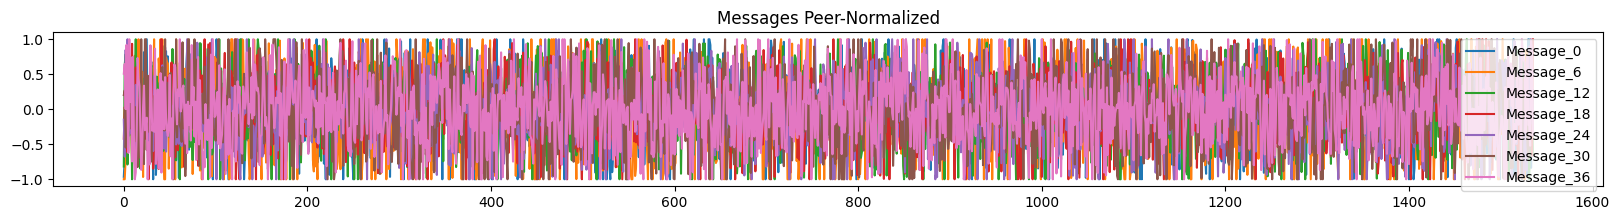

In [134]:
plt.figure(figsize=(20,2))
plt.title('Messages Peer-Normalized')
for message_id in df_messages.columns[::6]:
    plt.plot(df_messages[message_id], label=message_id)
plt.legend()
plt.show()

In [144]:
path_images = 'data/embeddings/images_embeddings.csv'
if REFRESH:
    df_images = pd.DataFrame([get_embedding(i) for i in images.Caption]).T
    df_images.columns = [f'Image_{i}' for i in df_images.columns]
    df_images.to_csv(path_images, index=False)
else:
    df_images = pd.read_csv(path_images)

In [145]:
df_images = prepare(df_images)

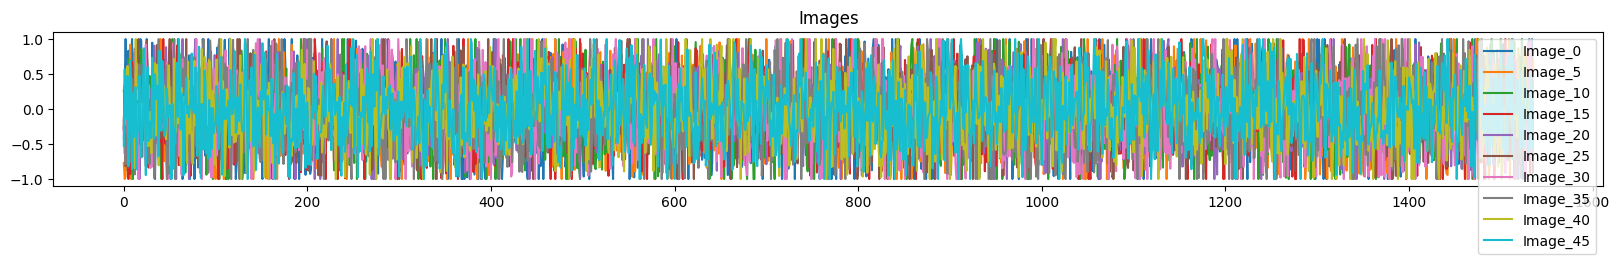

In [146]:
plt.figure(figsize=(20,2))
plt.title('Images')
for image_id in df_images.columns[::5]:
    plt.plot(df_images[image_id], label=image_id)
plt.legend()
plt.show()

# Get Distances

In [147]:
def get_cosine(vec_1, vec_2, epsilon=10**-6):
    """
    cosine() is so bad, that it's incapable
    of evaluating [0, 0] to [1, 1] distance
    due to zero division.
    Thus we manually bring it to live here
    """
    vec_1 = [i if i else epsilon for i in vec_1]
    vec_2 = [i if i else epsilon for i in vec_2]
    return cosine(vec_1, vec_2)

    
def ansnorm(vec_1, vec_2):
    """
    intended to work with -1 to 1 normalized vectors
    combines two approaches so that negatives of cosine similarity
    are smoothened as well as the negatives of euclidean alone
    """
    euc = euclidean(vec_1, vec_2)
    cos = get_cosine(vec_1, vec_2)
    # let's scale both distances to [0, 1]
    # since cosine() lies between 0 and 2, halve it    
    cos /= 2
    # now normalize the euclidean distance output
    # larges distances in our case are beteween
    # [-1, -1, ... , -1] and [1, 1, ... , 1]
    # and the value depends on n dimensions
    # so let's consider it
    ones = np.ones(len(vec_1))
    largest_euc = euclidean(-ones, ones)
    euc /= largest_euc    
    dist = euc/2 + euc*cos + cos/2
    # scale dist to [0, 1]
    dist /= 2
    # return euc, cos, dist  # an option for testing the function
    return dist

In [148]:
distances = {
    'activity-image': {},
    'activity-message': {},
    'person-image': {},
    'person-message': {},
    'image-message': {}
}

In [149]:
for activity in df_activities.columns:
    distances['activity-image'][activity] = {}
    distances['activity-message'][activity] = {}
    for image_id in df_images.columns:
        distances['activity-image'][activity][image_id] = ansnorm(df_activities[activity], df_images[image_id])
    for message_id in df_messages.columns:
        distances['activity-message'][activity][message_id] = ansnorm(df_activities[activity], df_messages[message_id])


In [150]:
df = prepare(pd.DataFrame(distances['activity-image']).T).T
df.index = images
df.style.background_gradient(cmap='YlGnBu')

,active,cerebral,creative,domestic,games,indoors,music,outdoors,physical,sports
"('male, young, indian, playing guitar, smiling, sitting',)",0.218770,1.000000,0.448913,0.472182,-0.244362,0.545040,-0.430028,0.441325,0.523886,0.279992
"('woman, adult, white, sitting at a desk, writing',)",0.085942,-0.536884,0.261614,-0.002629,-0.009486,-0.237212,0.511713,0.851193,0.350303,0.353917
"('woman, adult, white, preparing food, preparing food, cooking, cooking, cooking,',)",0.380654,0.123730,0.201086,-0.542310,0.233641,0.169760,0.842599,0.516556,0.275622,0.027686
"('senior, white, male, holding a book, walking',)",-0.113852,-0.570028,0.869444,0.622665,0.668554,0.367821,0.484174,0.471760,-0.275983,0.358321
"('female, adult, white, reading a book with a beagle',)",0.062558,-0.291269,0.535026,0.019106,0.032760,0.047112,0.762066,0.418748,-0.025226,0.342839
"('senior, white, male, sewing, working on a sewing machine',)",0.128454,-0.525007,-0.140830,-0.094848,0.527033,0.308894,0.714360,0.894314,0.112262,0.617280
"('female, young, adult, and smiling while leaning on the edge of a pool',)",-0.465808,0.676661,0.455756,0.384035,0.383206,0.041879,0.835251,0.094037,-0.022015,-0.434092
"('young, white, male, listening to music, headphones, outdoors',)",0.777758,0.517890,0.591129,0.885943,1.000000,-0.283283,-0.478597,-0.917220,0.427892,0.438633
"('male, adult, white, working on wood, making furniture',)",0.316286,0.443114,0.090912,-0.060151,0.571725,-0.027226,0.708139,0.397004,-0.169791,0.663402
"('female, young, asian, taking a photo with a camera',)",-0.021018,0.479397,-0.125238,0.005638,0.577010,0.279173,0.682779,0.349541,0.000248,0.328344


In [153]:
df = prepare(pd.DataFrame(distances['activity-message']).T).T
df.index = messages
df.style.background_gradient(cmap='YlGnBu')

,active,cerebral,creative,domestic,games,indoors,music,outdoors,physical,sports
"('Get up and groove! Dancing is your ticket to fun, fitness, and a break from the screen. Let the music move you!',)",-0.374721,0.943468,0.678761,0.710885,-0.270948,0.855362,-0.678872,0.648813,0.082744,-0.589616
"(""Ditch the screen, hit the trail! Discover nature's wonders, boost your mood, and energize your body with an invigorating hike."",)",-0.194049,0.512920,0.866332,0.601973,0.226729,0.359696,0.673415,-1.000000,-0.617292,-0.032385
"('Give your eyes a break and let your body flow with the ancient practice of yoga. Feel the tension melt away and experience the incredible benefits of increased flexibility, strength, and inner peace.',)",0.155274,0.261374,0.846514,0.338225,1.000000,0.579189,0.664603,0.341336,-1.000000,-0.017987
"(""Hey! Why not leave the screen behind and hop on your bike? Feel the wind in your hair, soak up the sunshine, and boost your mood while getting some exercise. Let's go biking and enjoy the great outdoors!"",)",-0.236994,0.508409,0.860242,0.719477,0.666839,0.165685,0.690015,-0.877495,0.255421,0.144670
"(""Step away from the screen and let's stroll! Walking boosts energy, clears the mind, and fills your day with fresh inspiration. Let's get moving!"",)",-0.821811,0.008750,0.268040,1.000000,0.350821,0.297449,0.333643,-0.140377,-0.196847,0.296188
"('Dive into the pool and feel the freedom! Swap screens for a refreshing swim, unleash your energy, and let the water ignite your senses.',)",-0.212492,0.685029,0.560640,0.534826,-0.098260,0.475632,1.000000,0.096729,-0.228262,0.146830
"('Why not give your thumbs a break and start pumping some iron? Weightlifting will boost your strength, tone your muscles, and leave you feeling unstoppable!',)",-0.184665,0.615401,0.943187,0.080467,0.612057,0.972290,0.791037,0.408491,-0.280263,-0.172936
"(""Hey! Ready to get moving? Put down the screen and let's hit the pavement - jogging boosts energy, reduces stress, and gives you a natural high! Let's go!"",)",-1.000000,0.212532,0.831059,0.552300,0.433569,0.750084,0.608752,0.059053,-0.717213,-0.049260
"(""Step away from the screen and let's roll! Experience the thrill of roller skating - it's exhilarating, boosts your mood, and keeps you active. Lace up and let the fun begin!"",)",-0.991477,0.497475,0.643681,0.732658,-0.198932,0.565604,0.546498,-0.066714,-0.686683,-0.913523
"(""Step away from the screen and tee off into a world of fun and relaxation! Golfing boosts your mood, improves focus, and gets you outdoors enjoying nature. Let's swing into action!"",)",-0.489799,0.427595,1.000000,0.469264,-0.117183,0.600102,0.514058,-0.602648,0.293747,-1.000000


In [154]:
for person_id in df_people_descriptions.columns:
    distances['person-image'][person_id] = {}
    distances['person-message'][person_id] = {}
    for image_id in df_images.columns:
        distances['person-image'][person_id][image_id] = ansnorm(df_people_descriptions[person_id], df_images[image_id])
    for message_id in df_messages.columns:
        distances['person-message'][person_id][message_id] = ansnorm(df_people_descriptions[person_id], df_messages[message_id])

In [168]:
df = prepare(pd.DataFrame(distances['person-image']).T).T
unique_people_decriptions = 'Age ' + df_people.age.astype(str) + ' ' + df_people.description
df.columns = unique_people_decriptions
df.index = images
df.style.background_gradient(cmap='YlGnBu')

,Age 45 adult white man,Age 33 young adult hispanic woman,Age 27 young adult asian man,Age 52 adult african american woman,Age 55 adult white man,Age 29 young adult asian woman,Age 65 senior-aged hispanic man,Age 38 adult african american woman,Age 70 senior-aged asian man,Age 21 young white woman,Age 39 adult hispanic man,Age 34 young adult african american woman,Age 58 adult white man,Age 46 adult asian woman,Age 49 adult hispanic man,Age 25 young adult african american woman,Age 31 young adult white man,Age 60 senior-aged asian woman,Age 35 adult hispanic man,Age 40 adult african american woman
"('male, young, indian, playing guitar, smiling, sitting',)",0.056699,0.195925,-0.703830,0.961834,0.056699,0.358808,-0.381668,0.961834,-0.340589,0.463082,-0.460747,0.844766,0.056699,0.672179,-0.460747,0.844766,-0.223280,0.541664,-0.460747,0.961834
"('woman, adult, white, sitting at a desk, writing',)",-0.440996,-0.586271,0.353475,-0.036874,-0.440996,-0.007332,0.566113,-0.036874,0.806130,-0.458138,0.274480,0.106344,-0.440996,-0.007119,0.274480,0.106344,-0.173094,0.159426,0.274480,-0.036874
"('woman, adult, white, preparing food, preparing food, cooking, cooking, cooking,',)",-0.331020,-0.486825,0.418349,-0.121243,-0.331020,-0.038200,0.659433,-0.121243,0.904142,-0.586507,0.215051,0.157790,-0.331020,-0.145685,0.215051,0.157790,-0.001900,0.160374,0.215051,-0.121243
"('senior, white, male, holding a book, walking',)",-0.509362,0.772318,0.203730,0.602652,-0.509362,0.956823,-0.892606,0.602652,-0.836722,0.180384,-0.054120,0.887828,-0.509362,0.985265,-0.054120,0.887828,-0.438374,-0.059258,-0.054120,0.602652
"('female, adult, white, reading a book with a beagle',)",-0.250790,-0.500001,0.453977,-0.157429,-0.250790,0.170689,0.280689,-0.157429,0.649951,-0.266055,0.180220,-0.102376,-0.250790,0.179247,0.180220,-0.102376,-0.019463,0.141662,0.180220,-0.157429
"('senior, white, male, sewing, working on a sewing machine',)",-0.392344,1.000000,0.394742,0.491114,-0.392344,1.000000,-0.989491,0.491114,-1.000000,0.113323,-0.049600,0.955406,-0.392344,0.797949,-0.049600,0.955406,-0.104201,-0.397135,-0.049600,0.491114
"('female, young, adult, and smiling while leaning on the edge of a pool',)",0.205757,-0.987540,0.086859,0.133476,0.205757,-0.119844,0.252098,0.133476,0.645256,-0.094188,0.126437,-0.018496,0.205757,0.044901,0.126437,-0.018496,0.059744,0.155699,0.126437,0.133476
"('young, white, male, listening to music, headphones, outdoors',)",-0.241604,-0.058874,-0.586955,0.898524,-0.241604,0.437371,-0.222922,0.898524,-0.010097,-0.220469,0.011113,0.184951,-0.241604,1.000000,0.011113,0.184951,-0.917359,0.785293,0.011113,0.898524
"('male, adult, white, working on wood, making furniture',)",-0.845822,0.252533,-0.529391,0.569969,-0.845822,0.538019,-0.110701,0.569969,-0.045754,0.521477,-0.898213,0.818247,-0.845822,0.350414,-0.898213,0.818247,-0.687449,0.913827,-0.898213,0.569969
"('female, young, asian, taking a photo with a camera',)",1.000000,-0.147996,-0.914943,0.636025,1.000000,-1.000000,0.748013,0.636025,-0.442037,-0.104489,1.000000,0.341853,1.000000,-0.581206,1.000000,0.341853,0.648068,-0.882060,1.000000,0.636025


In [163]:
df = prepare(pd.DataFrame(distances['person-message']).T).T
df.columns = unique_people_decriptions
df.index = messages
df.style.background_gradient(cmap='YlGnBu')

,Age 45 adult white man,Age 33 young adult hispanic woman,Age 27 young adult asian man,Age 52 adult african american woman,Age 55 adult white man,Age 29 young adult asian woman,Age 65 senior-aged hispanic man,Age 38 adult african american woman,Age 70 senior-aged asian man,Age 21 young white woman,Age 39 adult hispanic man,Age 34 young adult african american woman,Age 58 adult white man,Age 46 adult asian woman,Age 49 adult hispanic man,Age 25 young adult african american woman,Age 31 young adult white man,Age 60 senior-aged asian woman,Age 35 adult hispanic man,Age 40 adult african american woman
"('Get up and groove! Dancing is your ticket to fun, fitness, and a break from the screen. Let the music move you!',)",0.611951,-0.510727,0.113742,-0.504913,0.611951,0.491416,-0.439527,-0.504913,0.463960,0.135567,-0.192358,-1.000000,0.611951,0.994795,-0.192358,-1.000000,0.103083,0.263289,-0.192358,-0.504913
"(""Ditch the screen, hit the trail! Discover nature's wonders, boost your mood, and energize your body with an invigorating hike."",)",-0.006364,-0.181544,0.519123,-0.181707,-0.006364,0.558901,-0.488339,-0.181707,0.365173,-0.121131,-0.020800,0.146366,-0.006364,-0.116246,-0.020800,0.146366,0.221223,-0.116380,-0.020800,-0.181707
"('Give your eyes a break and let your body flow with the ancient practice of yoga. Feel the tension melt away and experience the incredible benefits of increased flexibility, strength, and inner peace.',)",1.000000,0.611883,-0.402090,0.268355,1.000000,-0.256851,0.376723,0.268355,-1.000000,0.338113,1.000000,0.483564,1.000000,-0.268678,1.000000,0.483564,0.588883,-1.000000,1.000000,0.268355
"(""Hey! Why not leave the screen behind and hop on your bike? Feel the wind in your hair, soak up the sunshine, and boost your mood while getting some exercise. Let's go biking and enjoy the great outdoors!"",)",-0.051416,0.031068,0.105099,0.456984,-0.051416,0.422921,-0.222010,0.456984,0.226048,-0.583163,0.091194,0.423874,-0.051416,0.514519,0.091194,0.423874,-0.543218,0.025339,0.091194,0.456984
"(""Step away from the screen and let's stroll! Walking boosts energy, clears the mind, and fills your day with fresh inspiration. Let's get moving!"",)",-0.494740,0.254244,0.126604,-0.529511,-0.494740,0.517759,-0.154946,-0.529511,-0.108257,-0.714454,0.107762,-0.337073,-0.494740,0.631128,0.107762,-0.337073,-0.677023,-0.077474,0.107762,-0.529511
"('Dive into the pool and feel the freedom! Swap screens for a refreshing swim, unleash your energy, and let the water ignite your senses.',)",0.307713,-0.372837,0.074057,-0.023676,0.307713,0.400051,0.030923,-0.023676,0.790054,0.186896,-0.557885,0.354218,0.307713,-0.355229,-0.557885,0.354218,0.003239,0.443630,-0.557885,-0.023676
"('Why not give your thumbs a break and start pumping some iron? Weightlifting will boost your strength, tone your muscles, and leave you feeling unstoppable!',)",-0.461489,1.000000,0.160552,0.287479,-0.461489,1.000000,0.762380,0.287479,1.000000,0.892805,0.251109,0.745777,-0.461489,0.762252,0.251109,0.745777,-0.584558,1.000000,0.251109,0.287479
"(""Hey! Ready to get moving? Put down the screen and let's hit the pavement - jogging boosts energy, reduces stress, and gives you a natural high! Let's go!"",)",0.433739,0.095770,-0.086677,0.341695,0.433739,0.753199,-0.476586,0.341695,0.138956,-0.041208,-0.079677,-0.204162,0.433739,1.000000,-0.079677,-0.204162,-0.483035,0.522939,-0.079677,0.341695
"(""Step away from the screen and let's roll! Experience the thrill of roller skating - it's exhilarating, boosts your mood, and keeps you active. Lace up and let the fun begin!"",)",0.114566,0.219021,-0.009450,-0.166259,0.114566,0.076044,0.382119,-0.166259,0.236512,-0.357657,0.345892,-0.521874,0.114566,0.162106,0.345892,-0.521874,-0.205827,-0.041154,0.345892,-0.166259
"(""Step away from the screen and tee off into a world of fun and relaxation! Golfing boosts your mood, improves focus, and gets you outdoors enjoying nature. Let's swing into action!"",)",-0.697375,0.457789,-0.23656

In [164]:
for image_id in df_images.columns:
    distances['image-message'][image_id] = {}
    for message_id in df_messages.columns:
        distances['image-message'][image_id][message_id] = ansnorm(df_images[image_id], df_messages[message_id])

In [165]:
df = prepare(pd.DataFrame(distances['image-message']).T).T
df.columns = images
df.index = messages
df.style.background_gradient(cmap='YlGnBu')

,"('male, young, indian, playing guitar, smiling, sitting',)","('woman, adult, white, sitting at a desk, writing',)","('woman, adult, white, preparing food, preparing food, cooking, cooking, cooking,',)","('senior, white, male, holding a book, walking',)","('female, adult, white, reading a book with a beagle',)","('senior, white, male, sewing, working on a sewing machine',)","('female, young, adult, and smiling while leaning on the edge of a pool',)","('young, white, male, listening to music, headphones, outdoors',)","('male, adult, white, working on wood, making furniture',)","('female, young, asian, taking a photo with a camera',)","('male, young, adult, and indonesian, and they are hiking',)","('male, adult, white, reading a newspaper, crossword puzzle',)","('male, young, adult, and they are making art with paper',)","('man, adult, white, cooking, frying, preparing food',)","('female, young, adult, white, sewing, working on a sewing machine',)","('woman, adult, afro-american, meditating, yoga',)","('young, white, male, chess, playing, chess',)","('senior, female, white, knitting, sitting at a table',)","('male, adult, black, watering plants in a kitchen',)","('male, adult, white, taking a photo with a camera',)","('female, young, adult, white, running in the park',)","('woman, adult, asian, putting flowers in a vase',)","('male, adult, black, golfing, teeing off',)","('senior, female, white, cutting a bush with scissors',)","('female, adult, white, and they are working on a puzzle',)","('female, adult, white, coloring a mandala',)","('female, adult, white, and they are writing calligraphy',)","('young, adult, black, looking up at the sky, hat',)","('woman, adult, white, carrying boxes, moving, moving boxes, moving, moving boxes, moving',)","('female, young, asian, jogging',)","('male, young, adult, and he is tying his shoe',)","('female, adult, asian, looking at the sky',)","('male, adult, white, and they are mowing the lawn',)","('young, white, male, backpack, hiking, mountain, forest, view',)","('senior, white, male, writing, drawing, painting, sketching',)","('male, young, black, reading to a baby, sitting in a chair',)","('female, adult, black, singing into a microphone, performing',)","('male, adult, white, writing at a table, preparing for a meeting',)","('male, adult, white, posing with a bike',)","('male, adult, senior, and they are doing yoga in the park',)","('woman, asian, adult, watering plants, watering plants',)","('woman, adult, white, cleaning the mirror, cleaning the house',)","('female, young, white, writing in a notebook,',)","('senior woman in floral dress with basket on bike in park with trees',)","(""senior, male, white, playing with a rubik's cube"",)","('female, adult, asian, working on a sculpture',)","('female, young, black, working on a project in a workshop',)","('female, young, adult, white, listening to music outdoors',)","('female, young, adult, and white, and they are lifting a barbell',)","('male, adult, black, walking a dog in the park',)"
"('Get up and groove! Dancing is your ticket to fun, fitness, and a break from the screen. Let the music move you!',)",-0.178988,0.420593,0.937674,0.337269,0.491963,0.659473,0.408308,-0.168244,0.648366,0.519476,0.484470,0.849889,0.733603,0.730163,0.666933,0.190363,0.416827,0.676404,0.808206,0.604441,-0.068523,0.754950,0.605687,1.000000,0.595733,0.646939,0.816668,0.461656,-0.692239,-0.174119,-0.079123,0.776259,0.713507,0.804646,0.707484,0.242923,-0.145702,0.567104,0.563079,0.019066,0.915029,0.637516,0.736892,0.209744,0.589413,0.847886,0.605081,-0.138107,0.127619,0.087992
"(""Ditch the screen, hit the trail! Discover nature's wonders, boost your mood, and energize your body with an invigorating hike."",)",0.590463,0.904459,0.833488,-0.384685,0.130640,1.000000,0.518435,-0.450352,0.875467,0.452807,-1.000000,0.730138,0.996781,0.861386,0.986907,0.448981,1.000000,0.837978,0.666810,0.528700,-0.881620,0.839988,0.555293,-0.669275,0.884403,0.708264,0.986920,-0.12234

In [166]:
# V1 preferences accent
images_for_people = {}
for person_id in df_people.index:
    images_for_people[person_id] = {}
    person_dislikes = df_people.loc[person_id]['dislikes']
    person_likes = df_people.loc[person_id]['likes']
    for image_id in df_images:
        demography_distance = distances['person-image'][person_id][image_id]
        cummulative_dislike_distance = 0
        for dislike in person_dislikes:
            dislike_distance = distances['activity-image'][dislike][image_id]
            cummulative_dislike_distance += dislike_distance
        cummulative_like_distance = 0
        for like in person_likes:
            like_distance = distances['activity-image'][like][image_id]
            cummulative_like_distance += like_distance
        personal_benchmark = demography_distance + cummulative_like_distance - cummulative_dislike_distance
        images_for_people[person_id][image_id] = personal_benchmark
df_images_for_people = pd.DataFrame(images_for_people)

In [169]:
df = prepare(df_images_for_people.T).T
df.columns = unique_people_decriptions + '\nDISLIKES\n' + df_people.dislikes.apply(lambda x: '\n'.join(x)) + '\nLIKES\n' + df_people.likes.apply(lambda x: '\n'.join(x))
df.index = images
df.style.background_gradient(cmap='YlGnBu')

,Age 45 adult white man DISLIKES sports games cerebral domestic LIKES physical creative music active,Age 33 young adult hispanic woman DISLIKES physical outdoors games cerebral LIKES domestic indoors music sports,Age 27 young adult asian man DISLIKES physical cerebral domestic indoors LIKES sports music active creative,Age 52 adult african american woman DISLIKES physical sports cerebral active LIKES creative domestic indoors music,Age 55 adult white man DISLIKES sports physical domestic active LIKES cerebral indoors creative music,Age 29 young adult asian woman DISLIKES sports indoors cerebral physical LIKES active creative music domestic,Age 65 senior-aged hispanic man DISLIKES physical music creative domestic LIKES indoors sports active cerebral,Age 38 adult african american woman DISLIKES sports physical creative domestic LIKES music indoors active cerebral,Age 70 senior-aged asian man DISLIKES creative cerebral domestic active LIKES physical music sports indoors,Age 21 young white woman DISLIKES sports indoors physical active LIKES domestic creative cerebral music,Age 39 adult hispanic man DISLIKES physical music domestic active LIKES sports indoors creative cerebral,Age 34 young adult african american woman DISLIKES sports physical creative domestic LIKES indoors music cerebral active,Age 58 adult white man DISLIKES indoors cerebral physical active LIKES creative domestic music sports,Age 46 adult asian woman DISLIKES physical music creative domestic LIKES active cerebral indoors sports,Age 49 adult hispanic man DISLIKES sports physical creative domestic LIKES music indoors cerebral active,Age 25 young adult african american woman DISLIKES sports indoors cerebral active LIKES physical creative domestic music,Age 31 young adult white man DISLIKES physical indoors creative domestic LIKES sports music active cerebral,Age 60 senior-aged asian woman DISLIKES sports cerebral physical active LIKES indoors domestic creative music,Age 35 adult hispanic man DISLIKES physical music creative domestic LIKES active indoors sports cerebral,Age 40 adult african american woman DISLIKES indoors physical creative active LIKES cerebral domestic music sports
"('male, young, indian, playing guitar, smiling, sitting',)",-0.284097,-0.217918,-0.972670,0.174392,-0.291062,-0.331077,0.292192,0.441110,-0.750663,-0.135366,0.325137,0.184925,-0.398978,1.000000,-0.762164,0.110809,-0.341108,-0.285307,0.176012,0.611819
"('woman, adult, white, sitting at a desk, writing',)",0.000148,-0.435179,0.254492,-0.145086,-0.524000,-0.125244,0.354740,-0.083455,0.535496,-0.625923,0.092425,-0.063583,-0.106173,-0.249321,-0.103824,0.182911,0.044120,-0.291709,0.035387,0.066699
"('woman, adult, white, preparing food, preparing food, cooking, cooking, cooking,',)",0.347856,-0.541967,0.392915,-0.306257,0.094074,-0.327351,0.800487,0.706845,0.789223,-0.764443,0.321280,0.711869,-0.589292,0.098282,0.778556,-0.113722,0.408999,-0.429989,0.415156,-0.215338
"('senior, white, male, holding a book, walking',)",-0.424097,0.693588,0.069235,0.784125,-0.412512,0.848449,-0.825583,0.067150,-0.712431,0.119141,0.127721,0.105193,0.453772,0.308948,-0.637396,0.796425,-0.436890,0.298242,-0.440128,0.671736
"('female, adult, white, reading a book with a beagle',)",0.152651,-0.023699,0.395447,0.021507,-0.074955,0.116558,0.169730,0.038804,0.400537,-0.317298,0.244205,0.002596,0.252367,-0.091186,0.062607,0.083003,0.152705,-0.037822,-0.025960,0.075338
"('senior, white, male, sewing, working on a sewing machine',)",-0.158199,0.320531,0.267540,0.125636,-0.399815,0.330976,-0.268413,0.699106,-0.041600,-0.505360,-0.026436,0.767600,-0.198325,0.893710,0.134438,0.315721,0.235443,-0.591872,0.223911,0.594451
"('female, young, adult, and smiling while leaning on the edge of a pool',)",0.142487,-0.313362,-0.238434,0.380878,0.484335,-0.008085,-0.143751,0.391439,0.045165,0.290119,0.059084,0.177187,0.562495,-0.569560,0.186476,0.371289,0.043929,0.219981,-0.373656,0.653893
"('young, white, male, listening to music, head

In [170]:
def string2paragraph(string, width):
    list_ = string.split(' ')
    current_word_number = 0
    paragraph = ''
    while True:
        finished_a_line = False
        line = ''
        while not finished_a_line:
            word = list_[current_word_number]
            if line:
                word = ' ' + word
            line += word
            if len(line) >= width:
                finished_a_line = True
            current_word_number += 1
            if current_word_number == len(list_):
                return paragraph + line
        if current_word_number == len(list_):
            return paragraph + line
        paragraph += line + '\n'

In [174]:
TOP_N = 3
for person_id in df_images_for_people:
    print('\n'*3)
    print(df_people.loc[person_id].description)
    print('likes:', ' '.join(df_people.loc[person_id].likes))
    print('dislikes:', ' '.join(df_people.loc[person_id].dislikes))
    personal_top_images = df_images_for_people[person_id].sort_values()[:TOP_N].index
    for n, image_id in enumerate(personal_top_images):
        print()
        print(n, end='. ')
        print(images.loc[image_id])
        best_message_id = sorted(distances['image-message'][image_id].items(), key=lambda x: [x[1]])[0][0]
        print('Message:')
        print(string2paragraph(messages.loc[best_message_id].content, 60))





adult white man
likes: physical creative music active
dislikes: sports games cerebral domestic

0. Caption    male, adult, white, taking a photo with a camera
Name: Image_19, dtype: object
Message:
Capture the world through your lens and unlock a world of creativity,
beauty, and self-expression. Embrace the magic of photography
and watch your screen time fade away!

1. Caption    male, young, adult, and they are making art wi...
Name: Image_12, dtype: object
Message:
Give your eyes a break and let your imagination soar! Grab a
pen and paper, and discover the joy of drawing while boosting
your creativity and reducing screen time.

2. Caption    young, white, male, listening to music, headph...
Name: Image_7, dtype: object
Message:
Why stare at screens when you can immerse yourself in the incredible
world of music? Let the captivating melodies transport you, boost
your mood, and ignite your imagination!




young adult hispanic woman
likes: domestic indoors music sports
dislikes: phy